# Dense Network

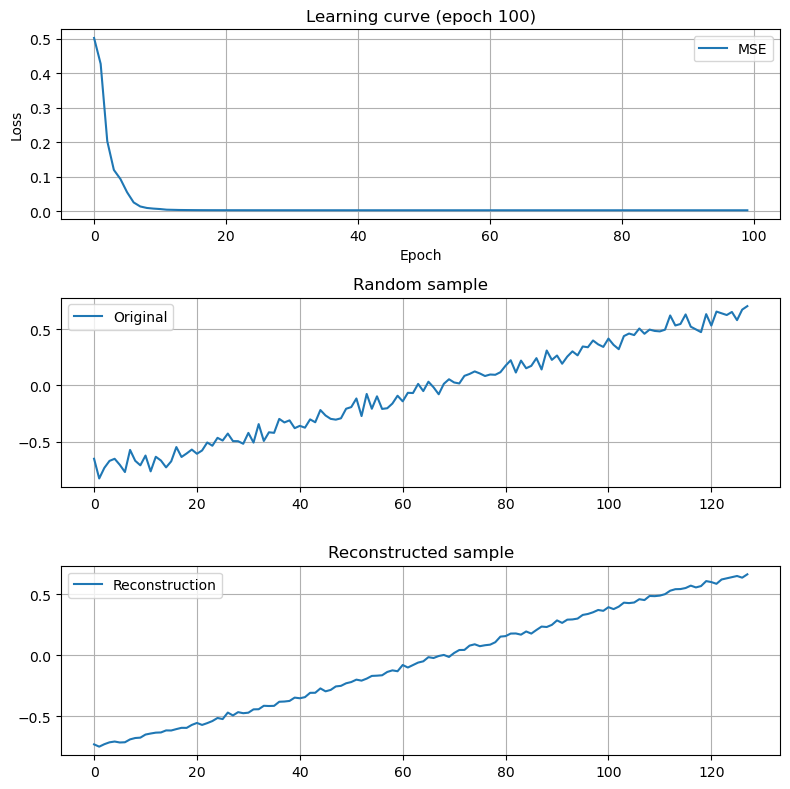

每筆樣本的重構 MSE (前 10 筆)：
 [0.00236181 0.00234036 0.00219189 0.00219369 0.0021768  0.00252934
 0.00209151 0.0018763  0.00236866 0.0023862 ]


In [2]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

# -------- Dense Autoencoder (reverse trick) --------
class DenseAutoencoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, hidden_dims=(128, 64)):
        super().__init__()
        # Encoder
        enc_layers = []
        prev = input_dim
        for h in hidden_dims:
            enc_layers += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        enc_layers += [nn.Linear(prev, latent_dim)]
        self.encoder = nn.Sequential(*enc_layers)

        # Decoder (對稱)
        dec_layers = []
        prev = latent_dim
        for h in reversed(hidden_dims):
            dec_layers += [nn.Linear(prev, h), nn.ReLU()]
            prev = h
        dec_layers += [nn.Linear(prev, input_dim)]
        self.decoder = nn.Sequential(*dec_layers)

    def forward(self, x):
        # x: [B, L]，先在時間維反轉
        x_rev = torch.flip(x, dims=[1])
        latent = self.encoder(x_rev)
        recon_rev = self.decoder(latent)
        # 再反轉回原順序
        recon = torch.flip(recon_rev, dims=[1])
        return recon

# -------- Agent 封裝 --------
class Agent:
    def __init__(
        self,
        input_dim: int,
        latent_dim: int = 16,
        hidden_dims=(128, 64),
        lr: float = 1e-3,
        device: str = None,
    ):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DenseAutoencoder(input_dim, latent_dim, hidden_dims).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.loss_history = []

    # ------------------------------------------------
    def train(self, dataloader: DataLoader, epochs: int = 100):
        # 隨機挑一筆樣本（batch 中第一筆）做視覺化
        sample_x = next(iter(dataloader))[0][0].to(self.device).unsqueeze(0)

        for epoch in range(1, epochs + 1):
            epoch_loss = 0.0
            for batch_x, in dataloader:
                batch_x = batch_x.to(self.device)
                self.optimizer.zero_grad()
                recon = self.model(batch_x)
                loss = self.criterion(recon, batch_x)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item() * batch_x.size(0)

            epoch_loss /= len(dataloader.dataset)
            self.loss_history.append(epoch_loss)

            # 每 10 epoch 繪圖一次
            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                with torch.no_grad():
                    recon_sample = self.model(sample_x).cpu().squeeze().numpy()
                clear_output(wait=True)  # 清屏 :contentReference[oaicite:2]{index=2}

                fig, axs = plt.subplots(3, 1, figsize=(8, 8))
                axs[0].plot(self.loss_history, label="MSE")
                axs[0].set_title(f"Learning curve (epoch {epoch})")
                axs[0].set_xlabel("Epoch")
                axs[0].set_ylabel("Loss")
                axs[0].legend()

                axs[1].plot(sample_x.cpu().squeeze().numpy(), label="Original")
                axs[1].set_title("Random sample")

                axs[2].plot(recon_sample, label="Reconstruction")
                axs[2].set_title("Reconstructed sample")

                for ax in axs:
                    ax.grid(True)
                    ax.legend()
                plt.tight_layout()
                plt.show()

    # ------------------------------------------------
    def predict(self, dataloader: DataLoader):
        self.model.eval()
        errors = []
        with torch.no_grad():
            for batch_x, in dataloader:
                batch_x = batch_x.to(self.device)
                recon = self.model(batch_x)
                mse = torch.mean((recon - batch_x) ** 2, dim=1)  # per-sample
                errors.extend(mse.cpu().numpy())
        self.model.train()
        return np.array(errors)

# -------- Main 示範 --------
if __name__ == "__main__":
    # 1. 生成 sin 波 + 噪聲
    total_len = 5000
    t = np.linspace(0, 50, total_len)
    y = np.sin(2 * np.pi * 0.2 * t) + 0.05 * np.random.randn(total_len)

    # 2. Sliding window 切分
    window = 128
    stride = 16
    segments = [
        y[i : i + window] for i in range(0, total_len - window + 1, stride)
    ]
    segments = np.stack(segments)          # shape: [N, window]
    dataset = TensorDataset(torch.tensor(segments, dtype=torch.float32))
    loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 3. 建立 Agent 並訓練
    agent = Agent(input_dim=window, latent_dim=32, hidden_dims=(256, 128))
    agent.train(loader, epochs=100)

    # 4. 重構誤差
    errors = agent.predict(loader)
    print("每筆樣本的重構 MSE (前 10 筆)：\n", errors[:10])


# LSTM-AutoEncoder

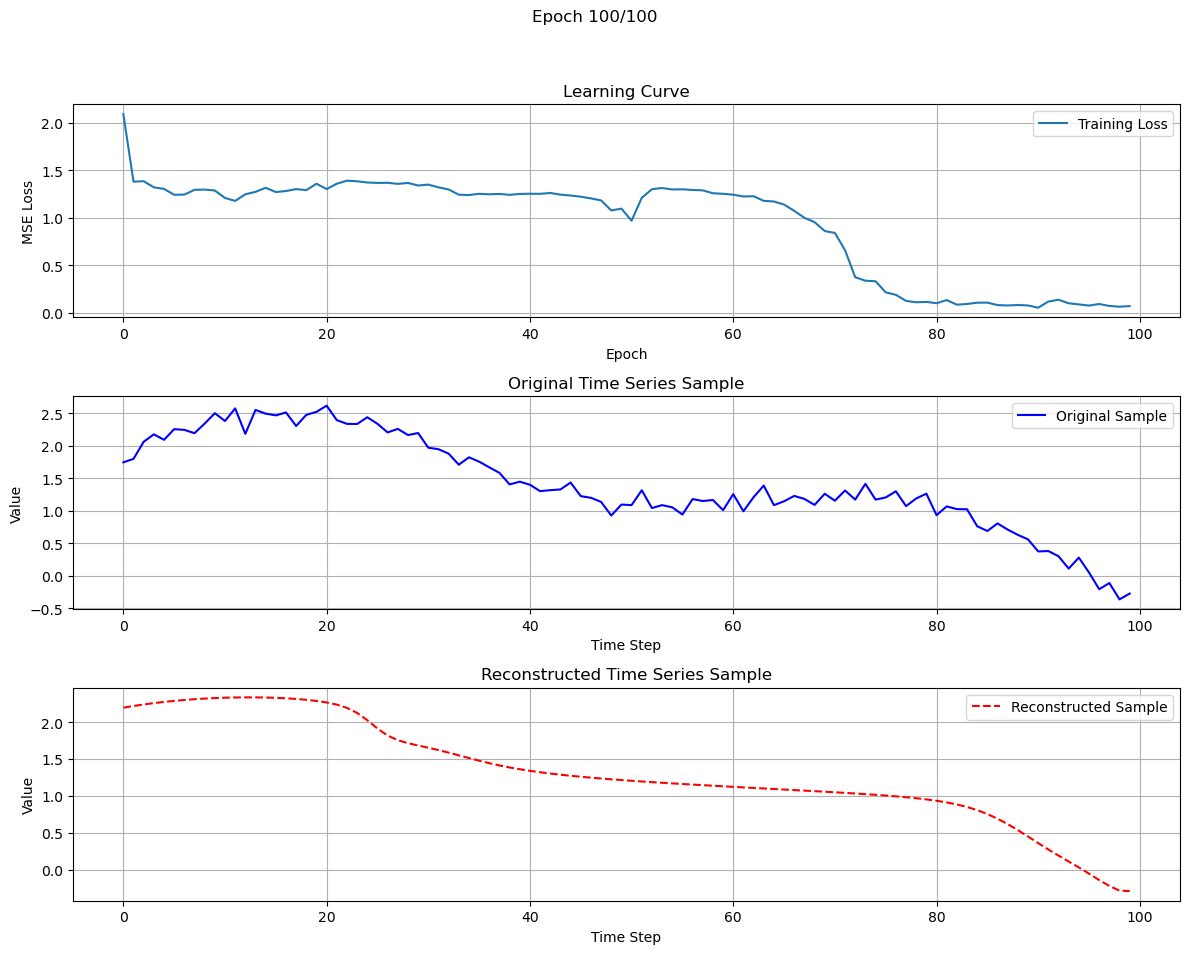

--- Training Finished ---

--- Calculating final reconstruction errors on the dataset ---
共計算了 1856 個樣本的重構誤差。
平均重構誤差 (MSE): 0.054779
重構誤差標準差: 0.035429


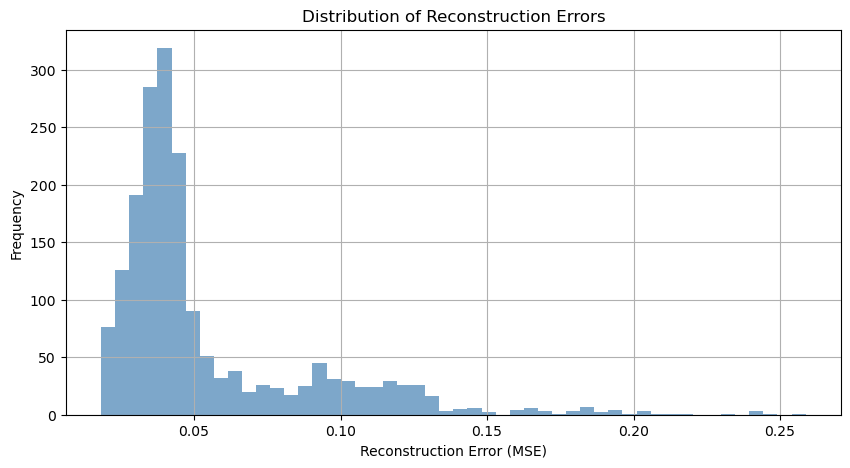

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# 確保程式碼的可重現性
torch.manual_seed(42)
np.random.seed(42)

# (1) 寫一個torch.nn.Module來建構一個LSTM模型
class ReconstructionLSTM(nn.Module):
    """
    一個使用LSTM的Encoder-Decoder模型，用於時間序列重構。
    Encoder 將輸入序列壓縮成一個潛在向量(context vector)。
    Decoder 利用此潛在向量來重構原始序列。
    """
    def __init__(self, seq_len, input_dim, latent_dim, hidden_dim, n_layers=2, dropout=0.2):
        super(ReconstructionLSTM, self).__init__()
        
        self.seq_len = seq_len
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.n_layers = n_layers

        # Encoder: 將序列 x -> 潛在向量 h
        self.encoder = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True, # 輸入格式為 (batch, seq_len, feature)
            dropout=dropout
        )
        
        # 將 Encoder 的 hidden state 映射到指定的 latent_dim
        self.fc_latent = nn.Linear(hidden_dim, latent_dim)

        # Decoder: 將潛在向量 h -> 重構序列 x'
        # 我們將使用 latent vector 來初始化 Decoder 的 hidden state
        self.decoder_init_fc = nn.Linear(latent_dim, hidden_dim)

        self.decoder = nn.LSTM(
            input_size=input_dim, # Decoder 的輸入可以是前一時刻的輸出(或是一個起始符號)
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            dropout=dropout
        )
        
        # 將 Decoder 的每個時間步的輸出映射回原始的維度
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        batch_size = x.size(0)
        
        # --- Encoder ---
        # encoder_outputs 的形狀: (batch_size, seq_len, hidden_dim)
        # hidden 的形狀: (n_layers, batch_size, hidden_dim)
        _, (hidden, cell) = self.encoder(x)
        
        # 我們取最後一層的 hidden state 作為序列的表示，並映射到 latent space
        # latent 的形狀: (batch_size, latent_dim)
        latent = self.fc_latent(hidden[-1])

        # --- Decoder ---
        # 將 latent vector 擴展回 decoder 所需的 hidden_dim
        # hidden_init 的形狀: (batch_size, hidden_dim)
        hidden_init = self.decoder_init_fc(latent)
        
        # 將 hidden_init 複製 n_layers 次，以初始化 Decoder 的所有層
        # decoder_hidden 的形狀: (n_layers, batch_size, hidden_dim)
        decoder_hidden = hidden_init.unsqueeze(0).repeat(self.n_layers, 1, 1)
        decoder_cell = torch.zeros_like(decoder_hidden) # cell state 初始化為 0

        # Decoder 的輸入: 為了引導 Decoder 生成，我們提供一個與輸入 x 同形狀的零張量
        # 這是重構任務中的一個常用技巧
        decoder_inputs = torch.zeros_like(x)
        
        # decoder_outputs 的形狀: (batch_size, seq_len, hidden_dim)
        decoder_outputs, _ = self.decoder(decoder_inputs, (decoder_hidden, decoder_cell))
        
        # 將 Decoder 的輸出通過全連接層，得到重構的序列
        # outputs 的形狀: (batch_size, seq_len, input_dim)
        outputs = self.output_layer(decoder_outputs)
        
        return outputs


# (4) 額外寫一個class agent
class LSTMAgent:
    """
    一個代理類，封裝了模型、訓練邏輯和預測邏輯。
    """
    def __init__(self, seq_len, input_dim=1, latent_dim=16, hidden_dim=64, n_layers=2, lr=1e-3, device=None):
        # (6) agent內建好模型的設定
        self.seq_len = seq_len
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lr = lr
        
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Agent is using device: {self.device}")
        
        self.model = ReconstructionLSTM(
            seq_len=self.seq_len,
            input_dim=self.input_dim,
            latent_dim=self.latent_dim,
            hidden_dim=self.hidden_dim,
            n_layers=self.n_layers
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss(reduction='mean')
        self.history = {'train_loss': []}

    # (5) agent上寫.train和.predict
    # (7) .train的input為dataloader和epochs...
    def train(self, dataloader, epochs):
        self.model.train()
        
        # 從 dataloader 中隨機挑一筆 sample 出來，用於後續繪圖
        # 為了穩定性，我們取第一個 batch 的第一筆資料
        sample_to_plot = next(iter(dataloader))[0][:1].to(self.device)

        print("--- Starting Training ---")
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch_features, in dataloader:
                batch_features = batch_features.to(self.device)
                
                self.optimizer.zero_grad()
                
                # 模型輸出
                outputs = self.model(batch_features)
                
                # (3) 採取重構上的reverse tricks
                # 我們的目標是讓模型輸出反轉後的原始序列
                target = torch.flip(batch_features, dims=[1])
                
                loss = self.criterion(outputs, target)
                
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.item()
            
            avg_epoch_loss = epoch_loss / len(dataloader)
            self.history['train_loss'].append(avg_epoch_loss)
            
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_epoch_loss:.6f}")
            
            # 每 10 個 epoch 繪製結果
            if (epoch + 1) % 10 == 0:
                # (8) 每次畫圖前會先呼叫clear_output()
                clear_output(wait=True)
                
                self.model.eval()
                with torch.no_grad():
                    # 取得繪圖樣本的重構結果
                    reconstructed_output = self.model(sample_to_plot)
                    # 因為模型學會了輸出反轉序列，所以要把它翻轉回來才能跟原始序列比較
                    reconstructed_sample = torch.flip(reconstructed_output, dims=[1])
                
                self.model.train()

                # 將 tensor 移至 cpu 並轉為 numpy
                original = sample_to_plot.squeeze().cpu().numpy()
                reconstructed = reconstructed_sample.squeeze().cpu().numpy()
                
                # 建立 3x1 的子圖
                fig, axes = plt.subplots(3, 1, figsize=(12, 10))
                fig.suptitle(f'Epoch {epoch+1}/{epochs}')
                
                # 圖一：學習曲線 (Epoch-Loss Learning Curve)
                axes[0].plot(self.history['train_loss'], label='Training Loss')
                axes[0].set_title('Learning Curve')
                axes[0].set_xlabel('Epoch')
                axes[0].set_ylabel('MSE Loss')
                axes[0].legend()
                axes[0].grid(True)
                
                # 圖二：原始樣本 (Sample)
                axes[1].plot(original, label='Original Sample', color='blue')
                axes[1].set_title('Original Time Series Sample')
                axes[1].set_xlabel('Time Step')
                axes[1].set_ylabel('Value')
                axes[1].legend()
                axes[1].grid(True)

                # 圖三：重構樣本 (Sample Reconstruction)
                axes[2].plot(reconstructed, label='Reconstructed Sample', color='red', linestyle='--')
                axes[2].set_title('Reconstructed Time Series Sample')
                axes[2].set_xlabel('Time Step')
                axes[2].set_ylabel('Value')
                axes[2].legend()
                axes[2].grid(True)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

        print("--- Training Finished ---")

    # (9) .predict則是輸入dataloader，然後會給出重構誤差分數（by sample）
    def predict(self, dataloader):
        self.model.eval()
        reconstruction_errors = []
        
        with torch.no_grad():
            for batch_features, in dataloader:
                batch_features = batch_features.to(self.device)
                
                outputs = self.model(batch_features)
                target = torch.flip(batch_features, dims=[1])
                
                # 計算每個樣本的 MSE
                # (outputs - target)**2 的形狀: (batch_size, seq_len, input_dim)
                # 我們在 seq_len 和 input_dim 維度上取平均
                errors = torch.mean((outputs - target)**2, dim=[1, 2])
                reconstruction_errors.extend(errors.cpu().numpy())
                
        return np.array(reconstruction_errors)


# (10) 最後寫主程式
if __name__ == '__main__':
    # --- 1. 生成合成資料：sin波 + 隨機擾動 ---
    data_points = 2000
    t = np.linspace(0, 400, data_points)
    # 結合兩個不同頻率的 sin 波，增加複雜度
    amplitude1, amplitude2 = 2, 0.5
    frequency1, frequency2 = 0.1, 0.5
    noise_level = 0.1
    
    time_series_data = amplitude1 * np.sin(frequency1 * t) + amplitude2 * np.sin(frequency2 * t) + np.random.normal(0, noise_level, data_points)
    
    print(f"原始時間序列資料形狀: {time_series_data.shape}")

    # --- 2. 寫 sliding windows 切分程式碼 ---
    def create_sequences(data, seq_length):
        xs = []
        for i in range(len(data) - seq_length):
            x = data[i:(i + seq_length)]
            xs.append(x)
        return np.array(xs)

    SEQ_LENGTH = 100
    X = create_sequences(time_series_data, SEQ_LENGTH)
    
    # 將資料轉換為 PyTorch Tensor，並增加一個 feature 維度
    # LSTM 需要的輸入格式為 (batch_size, seq_len, input_dim)
    X_tensor = torch.from_numpy(X).float().unsqueeze(2)
    print(f"經過 sliding window 處理後的資料形狀: {X_tensor.shape}")

    # --- 3. 建立 DataLoader ---
    BATCH_SIZE = 64
    dataset = TensorDataset(X_tensor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    # --- 4. 建構 agent 並進行訓練 ---
    lstm_agent = LSTMAgent(
        seq_len=SEQ_LENGTH,
        input_dim=1,
        latent_dim=32,   # 潛在空間維度
        hidden_dim=128,  # LSTM 隱藏層維度
        n_layers=2,
        lr=1e-3
    )

    # 執行訓練，訓練過程會自動繪圖
    lstm_agent.train(dataloader, epochs=100)

    # --- 5. 進行預測並評估重構誤差 ---
    print("\n--- Calculating final reconstruction errors on the dataset ---")
    errors = lstm_agent.predict(dataloader)
    print(f"共計算了 {len(errors)} 個樣本的重構誤差。")
    print(f"平均重構誤差 (MSE): {np.mean(errors):.6f}")
    print(f"重構誤差標準差: {np.std(errors):.6f}")
    
    # 繪製誤差分佈圖
    plt.figure(figsize=(10, 5))
    plt.hist(errors, bins=50, alpha=0.7, color='steelblue')
    plt.xlabel("Reconstruction Error (MSE)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Reconstruction Errors")
    plt.grid(True)
    plt.show()

# 1DCNN AutoEncoder

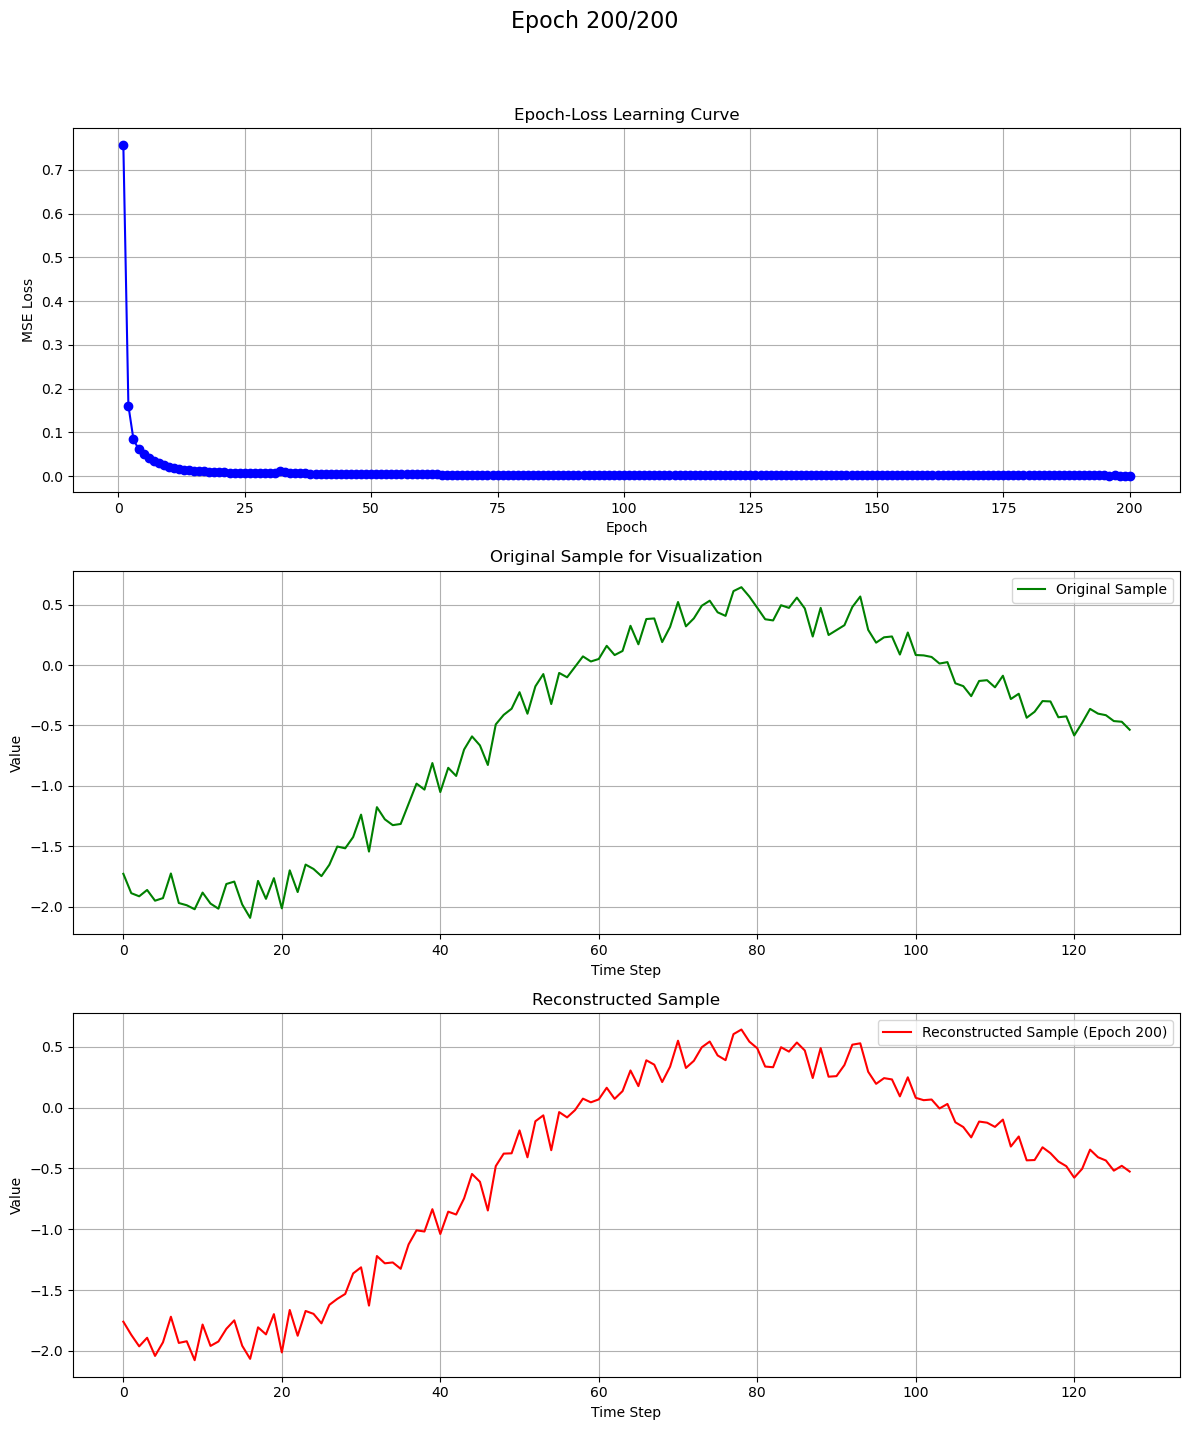

Training finished.

Demonstrating .predict() function...
Calculated reconstruction errors for 1872 samples.


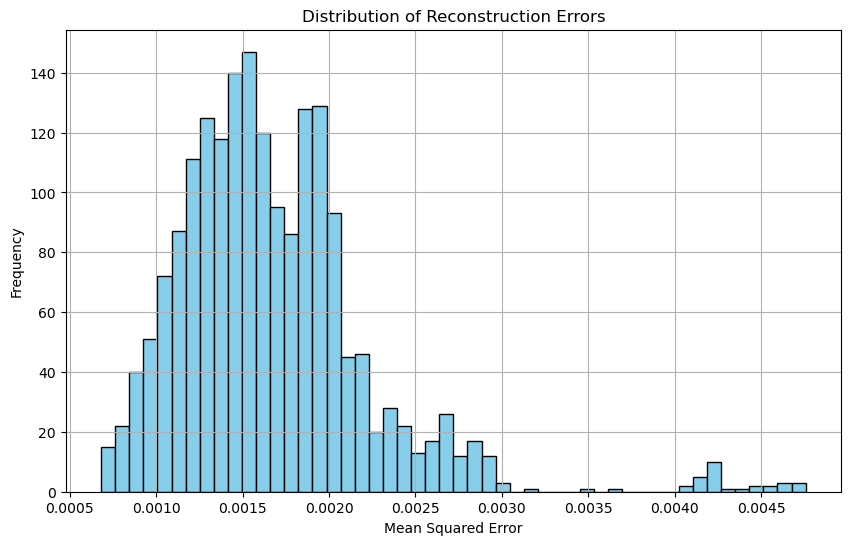

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# (1) 寫一個torch.nn.Module來建構一個1DCNN模型
# (2) 目標是時間序列的重構任務
# (3) 必須採取重構上的reverse tricks (MaxPool1d -> MaxUnpool1d, Conv1d -> ConvTranspose1d)
class Reconstruction1DCNN(nn.Module):
    def __init__(self, seq_len, latent_dim_channels=32):
        super(Reconstruction1DCNN, self).__init__()
        
        # --- Encoder ---
        # 網路結構的設計需要確保維度可以被 Pool 層整除
        # Input: (N, 1, seq_len)
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        # Pool 層會讓序列長度減半
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True) 
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=latent_dim_channels, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        # Pool 層再次讓序列長度減半
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, return_indices=True)
        
        # --- Decoder (The "Reverse Trick") ---
        # 順序與 Encoder 相反
        # Unpool 層會讓序列長度加倍
        self.unpool2 = nn.MaxUnpool1d(kernel_size=2, stride=2)
        self.deconv2 = nn.ConvTranspose1d(in_channels=latent_dim_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        # Unpool 層會讓序列長度加倍
        self.unpool1 = nn.MaxUnpool1d(kernel_size=2, stride=2)
        self.deconv1 = nn.ConvTranspose1d(in_channels=16, out_channels=1, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        # --- Encoder Pass ---
        # 記住原始尺寸，以便 unpooling 時使用
        original_size1 = x.size()
        x = self.relu1(self.conv1(x))
        x, indices1 = self.pool1(x)
        
        original_size2 = x.size()
        x = self.relu2(self.conv2(x))
        x, indices2 = self.pool2(x)
        
        # Latent representation is `x` at this point
        
        # --- Decoder Pass ---
        # 使用儲存的 indices 來進行 unpooling
        x = self.unpool2(x, indices2, output_size=original_size2)
        x = self.relu3(self.deconv2(x))
        
        x = self.unpool1(x, indices1, output_size=original_size1)
        reconstructed_x = self.deconv1(x) # 最後一層通常不加激活函數
        
        return reconstructed_x

# (4) 額外寫一個class agent
# (5) agent上寫.train和.predict
# (6) agent內建好模型的設定（包含各層設定、latent dim設定）
class Agent:
    def __init__(self, seq_len, latent_dim_channels=32, learning_rate=1e-3):
        """
        Agent的建構子，負責初始化模型、優化器和損失函數。
        """
        print("Initializing Agent...")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # 內建模型設定
        self.seq_len = seq_len
        self.latent_dim_channels = latent_dim_channels
        self.model = Reconstruction1DCNN(
            seq_len=self.seq_len, 
            latent_dim_channels=self.latent_dim_channels
        ).to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        print("Model, Optimizer, and Criterion are set.")
        print("Model Architecture:")
        print(self.model)

    # (7) .train的input為dataloader和epochs，會從dataloader中隨機挑一筆sample出來，然後訓練
    #     每10個epoch會用plt.suplots去畫epoch-loss的Learning curve、sample畫圖、sample重構畫圖
    # (8) 每次畫圖前會先呼叫clear_output()
    def train(self, dataloader, epochs):
        """
        訓練模型，並在過程中動態繪製學習曲線和重構結果。
        """
        self.model.train()
        epoch_losses = []
        
        # 從 dataloader 中隨機挑一筆 sample 用於畫圖
        # 我們取第一筆 batch 的第一筆 data
        sample_to_plot = next(iter(dataloader))[0][0:1].to(self.device)

        print("\nStarting training...")
        for epoch in range(epochs):
            batch_losses = []
            for data_batch, in dataloader:
                data_batch = data_batch.to(self.device)
                
                # Forward pass
                reconstructed = self.model(data_batch)
                loss = self.criterion(reconstructed, data_batch)
                
                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                batch_losses.append(loss.item())
            
            epoch_loss = np.mean(batch_losses)
            epoch_losses.append(epoch_loss)
            
            # 每 10 個 epoch 更新一次圖表
            if (epoch + 1) % 10 == 0:
                # (8) 每次畫圖前會先呼叫clear_output()
                clear_output(wait=True)
                
                self.model.eval() # 切換到評估模式以進行預測
                with torch.no_grad():
                    reconstructed_sample = self.model(sample_to_plot)
                self.model.train() # 切換回訓練模式
                
                # (7) ...用plt.suplots去畫圖
                fig, axs = plt.subplots(3, 1, figsize=(12, 15))
                fig.suptitle(f'Epoch {epoch + 1}/{epochs}', fontsize=16)

                # 圖一: Learning Curve
                axs[0].plot(range(1, epoch + 2), epoch_losses, marker='o', color='b')
                axs[0].set_title('Epoch-Loss Learning Curve')
                axs[0].set_xlabel('Epoch')
                axs[0].set_ylabel('MSE Loss')
                axs[0].grid(True)

                # 圖二: 原始樣本
                axs[1].plot(sample_to_plot.cpu().numpy().flatten(), label='Original Sample', color='g')
                axs[1].set_title('Original Sample for Visualization')
                axs[1].set_xlabel('Time Step')
                axs[1].set_ylabel('Value')
                axs[1].legend()
                axs[1].grid(True)
                
                # 圖三: 重構樣本
                axs[2].plot(reconstructed_sample.cpu().numpy().flatten(), label=f'Reconstructed Sample (Epoch {epoch+1})', color='r')
                axs[2].set_title('Reconstructed Sample')
                axs[2].set_xlabel('Time Step')
                axs[2].set_ylabel('Value')
                axs[2].legend()
                axs[2].grid(True)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

        print("Training finished.")

    # (9) .predict則是輸入dataloader，然後會給出重構誤差分數（by sample）
    def predict(self, dataloader):
        """
        使用訓練好的模型進行預測，並返回每個樣本的重構誤差。
        """
        self.model.eval() # 確保模型在評估模式
        recon_errors = []
        with torch.no_grad():
            for data_batch, in dataloader:
                data_batch = data_batch.to(self.device)
                reconstructed = self.model(data_batch)
                
                # 計算每個 sample 的 MSE
                # (N, C, L) -> (N)
                errors = torch.mean((reconstructed - data_batch) ** 2, dim=[1, 2])
                recon_errors.extend(errors.cpu().numpy())
        
        return np.array(recon_errors)


# (10) 最後寫主程式，會建構這個agent，然後以sin波 + 隨機擾動做一個時間序列的樣本，
#      接著寫sliding windows切分程式碼，然後帶到這個模型當中做.train，並得出訓練效果圖
if __name__ == '__main__':
    # --- 參數設定 ---
    # 注意: SEQ_LEN 必須是 4 的倍數，因為我們有兩次 kernel_size=2, stride=2 的 MaxPool1d
    SEQ_LEN = 128 
    N_SAMPLES = 2000
    NOISE_FACTOR = 0.1
    EPOCHS = 200
    BATCH_SIZE = 64
    
    # --- 生成數據 ---
    print("Generating synthetic data...")
    t = np.linspace(0, 400, N_SAMPLES)
    # Sin波 + 隨機擾動
    series = np.sin(0.1 * t) + np.sin(0.25 * t) + np.random.normal(0, NOISE_FACTOR, N_SAMPLES)
    
    # --- Sliding Windows 切分 ---
    def sliding_windows(data, seq_length):
        x = []
        for i in range(len(data) - seq_length):
            _x = data[i:(i + seq_length)]
            x.append(_x)
        return np.array(x)

    print("Applying sliding windows...")
    samples = sliding_windows(series, SEQ_LEN)
    # 增加 channel 維度 (N, L) -> (N, 1, L)
    samples_tensor = torch.from_numpy(samples).float().unsqueeze(1)
    
    # --- 建立 DataLoader ---
    dataset = TensorDataset(samples_tensor)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # --- 建立 Agent 並開始訓練 ---
    agent = Agent(seq_len=SEQ_LEN)
    agent.train(dataloader, epochs=EPOCHS)
    
    # --- (可選) 演示 .predict 功能 ---
    print("\nDemonstrating .predict() function...")
    reconstruction_errors = agent.predict(dataloader)
    print(f"Calculated reconstruction errors for {len(reconstruction_errors)} samples.")
    
    # 畫出誤差分佈
    plt.figure(figsize=(10, 6))
    plt.hist(reconstruction_errors, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Reconstruction Errors')
    plt.xlabel('Mean Squared Error')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# MEMTO

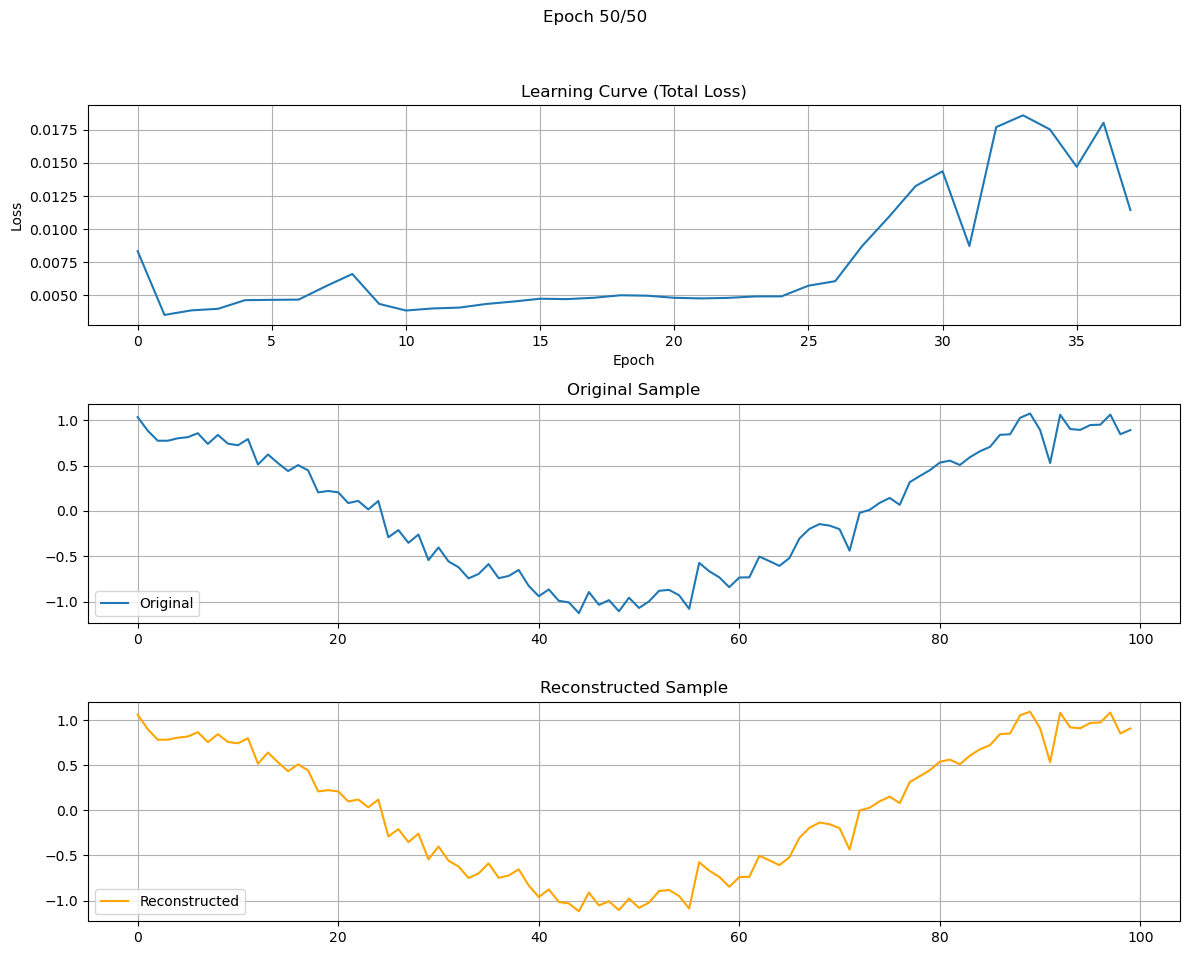

====== Training Finished ======

Generating test data...

====== Starting Prediction ======
====== Prediction Finished ======


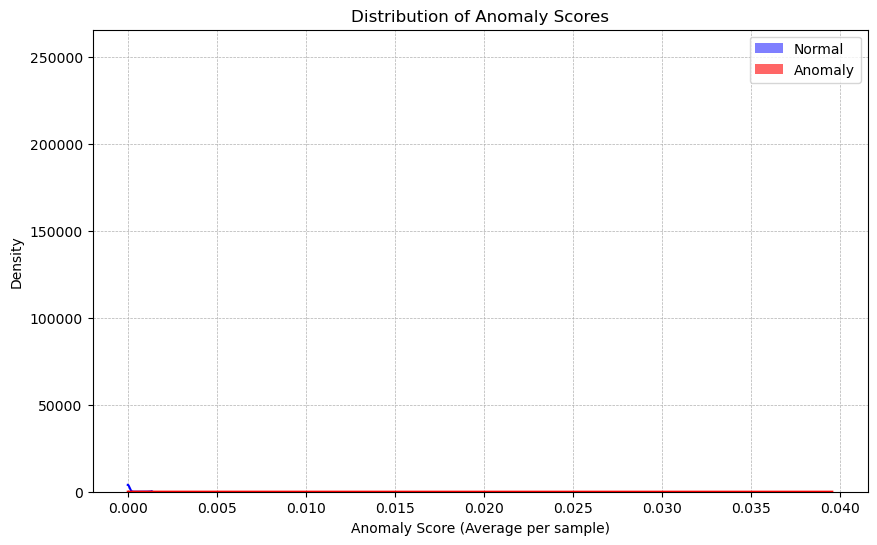

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.cluster import KMeans
from IPython.display import display, clear_output
import math
import seaborn as sns
import warnings

# 忽略KMeans在單CPU上可能產生的內存洩漏警告
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.cluster._kmeans')


# =========== 1. MEMTO 模型 (torch.nn.Module) ===========
# 完全遵循論文架構

class PositionalEncoding(nn.Module):
    """標準的Transformer位置編碼"""
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class MEMTO_Model(nn.Module):
    """
    MEMTO 模型實現
    完全遵循 memto.pdf 的設計
    """
    def __init__(self, input_dim, feature_dim, n_heads, n_layers, mem_dim, tau=0.1, dropout=0.1):
        super(MEMTO_Model, self).__init__()
        
        self.feature_dim = feature_dim
        self.mem_dim = mem_dim
        self.tau = tau

        # --- Encoder ---
        self.input_projection = nn.Linear(input_dim, feature_dim)
        self.pos_encoder = PositionalEncoding(feature_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model=feature_dim, nhead=n_heads, dim_feedforward=feature_dim*4, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=n_layers)

        # --- Gated Memory Module ---
        # Memory Items
        self.memory = nn.Parameter(torch.randn(mem_dim, feature_dim))
        
        # Gated Memory Update Stage 的線性投影層 (公式 2)
        self.U_psi = nn.Linear(feature_dim, feature_dim, bias=False)
        self.W_psi = nn.Linear(feature_dim, feature_dim, bias=False)

        # --- Weak Decoder ---
        # 輸入維度為 2*feature_dim，因為是 query 和 retrieved memory 的拼接 (concat)
        self.decoder = nn.Sequential(
            nn.Linear(2 * feature_dim, feature_dim),
            nn.ReLU(),
            nn.Linear(feature_dim, input_dim)
        )

    def forward(self, src, training_phase='phase2'):
        # src shape: (batch_size, seq_len, input_dim)
        
        # --- 1. Encoder ---
        # 論文的Transformer輸入是 (seq_len, batch_size, feature_dim)
        # PyTorch的TransformerEncoderLayer設定batch_first=True後，可接受 (batch_size, seq_len, feature_dim)
        queries = self.input_projection(src)
        queries = self.transformer_encoder(queries) # shape: (batch_size, seq_len, feature_dim)
        
        # --- 2. Gated Memory Module ---
        
        # 論文中的公式是針對單一樣本 s 操作，這裡我們用 batch 方式高效計算
        
        # --- 2a. Gated Memory Update Stage (僅在 Phase 2 訓練時執行) ---
        if self.training and training_phase == 'phase2':
            # 公式 1: query-conditioned memory attention (v_i,t^s)
            # (m_i, q_t^s) -> (batch, mem_dim, feature_dim) @ (batch, feature_dim, seq_len) -> (batch, mem_dim, seq_len)
            q_T = queries.permute(0, 2, 1) # (batch, feature_dim, seq_len)
            mem_expanded = self.memory.unsqueeze(0).expand(src.size(0), -1, -1) # (batch, mem_dim, feature_dim)
            v_s = torch.softmax((mem_expanded @ q_T) / self.tau, dim=-1) # shape: (batch, mem_dim, seq_len)
            
            # v_s @ queries -> (batch, mem_dim, seq_len) @ (batch, seq_len, feature_dim) -> (batch, mem_dim, feature_dim)
            new_info = v_s @ queries
            
            # 公式 2: Update gate (psi)
            psi = torch.sigmoid(self.U_psi(mem_expanded) + self.W_psi(new_info)) # shape: (batch, mem_dim, feature_dim)
            
            # 公式 3: Memory update
            # 更新是增量的，對所有 batch 的更新取平均
            m_new_batch = (1 - psi) * mem_expanded + psi * new_info
            m_new = m_new_batch.mean(dim=0) # shape: (mem_dim, feature_dim)
            
            # 用 .data 更新，避免在反向傳播圖中產生循環
            self.memory.data = m_new

        # --- 2b. Query Update Stage (訓練與推論) ---
        # 公式 4: memory-conditioned query-attention (w_t,i^s)
        # (q_t^s, m_i) -> (batch, seq_len, feature_dim) @ (batch, feature_dim, mem_dim) -> (batch, seq_len, mem_dim)
        mem_T = self.memory.t().unsqueeze(0).expand(src.size(0), -1, -1) # (batch, feature_dim, mem_dim)
        w_s = torch.softmax((queries @ mem_T) / self.tau, dim=-1) # shape: (batch, seq_len, mem_dim)

        # 公式 5: retrieved memory item (q_tilde_t^s)
        # (batch, seq_len, mem_dim) @ (batch, mem_dim, feature_dim) -> (batch, seq_len, feature_dim)
        retrieved_memory = w_s @ self.memory.unsqueeze(0).expand(src.size(0), -1, -1)
        
        # --- 3. Decoder ---
        # 拼接 query 和 retrieved memory (論文圖 1 的紅色箭頭) [cite: 57]
        updated_queries = torch.cat([queries, retrieved_memory], dim=2) # shape: (batch, seq_len, 2*feature_dim)
        
        reconstructed_src = self.decoder(updated_queries)
        
        return reconstructed_src, w_s, queries

# =========== 2. Agent 類別 ===========
# 負責模型訓練、預測、視覺化等流程控制

class MEMTOAgent:
    def __init__(self, input_dim, seq_len, feature_dim=64, n_heads=4, n_layers=3, mem_dim=10, lr=5e-5, lambda_entropy=0.01):
        print("Initializing MEMTO Agent...")
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        # 模型設定
        self.model = MEMTO_Model(
            input_dim=input_dim,
            feature_dim=feature_dim,
            n_heads=n_heads,
            n_layers=n_layers,
            mem_dim=mem_dim,
        ).to(self.device)
        
        self.seq_len = seq_len
        self.mem_dim = mem_dim
        self.feature_dim = feature_dim

        # 優化器與損失函數
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.rec_loss_fn = nn.MSELoss()
        self.lambda_entropy = lambda_entropy
        
        # 訓練歷史
        self.loss_history = []
        print("Agent initialized.")

    def _calculate_loss(self, src, reconstructed_src, w, phase):
        rec_loss = self.rec_loss_fn(src, reconstructed_src)
        
        if phase == 'phase1':
            return rec_loss
        
        # 公式 7: Entropy loss
        entropy_loss = -w * torch.log(w + 1e-12)
        entropy_loss = entropy_loss.sum(dim=-1).mean()
        
        # 公式 8: Total loss
        total_loss = rec_loss + self.lambda_entropy * entropy_loss
        return total_loss

    def _initialize_memory_with_kmeans(self, data_loader):
        print("\n--- Starting K-means Memory Initialization ---")
        self.model.eval()
        all_queries = []
        with torch.no_grad():
            for batch_x, in data_loader:
                batch_x = batch_x.to(self.device)
                queries = self.model.input_projection(batch_x)
                queries = self.model.transformer_encoder(queries)
                all_queries.append(queries.reshape(-1, self.feature_dim).cpu().numpy())
        
        all_queries = np.concatenate(all_queries, axis=0)
        
        print(f"Running K-means on {all_queries.shape[0]} query vectors...")
        kmeans = KMeans(n_clusters=self.mem_dim, n_init=10) # 論文使用 K-means 
        kmeans.fit(all_queries)
        
        centroids = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32).to(self.device)
        self.model.memory.data = centroids
        print("Memory items initialized with K-means centroids.")

    def train(self, dataloader, epochs):
        print("\n====== Starting Training Process ======")
        # 從 dataloader 中隨機挑一筆 sample 用於視覺化
        sample_batch, = next(iter(dataloader))
        visual_sample = sample_batch[0].unsqueeze(0).to(self.device)

        total_steps = len(dataloader)
        phase1_epochs = max(1, epochs // 4) # 分配約 1/4 的 epoch 給 Phase 1
        
        # --- Phase 1: 訓練基礎 Encoder ---
        print(f"\n--- Phase 1: Encoder Training ({phase1_epochs} Epochs) ---")
        for epoch in range(phase1_epochs):
            self.model.train()
            total_loss = 0
            for i, (batch_x,) in enumerate(dataloader):
                batch_x = batch_x.to(self.device)
                self.optimizer.zero_grad()
                reconstructed, _, _ = self.model(batch_x, training_phase='phase1')
                loss = self._calculate_loss(batch_x, reconstructed, None, 'phase1')
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            
            avg_loss = total_loss / total_steps
            print(f"Phase 1 | Epoch {epoch+1}/{phase1_epochs}, Loss: {avg_loss:.6f}")

        # --- K-means 初始化 ---
        self._initialize_memory_with_kmeans(dataloader)
        
        # --- Phase 2: 完整 MEMTO 訓練 ---
        print(f"\n--- Phase 2: Full MEMTO Training ({epochs - phase1_epochs} Epochs) ---")
        for epoch in range(phase1_epochs, epochs):
            self.model.train()
            total_loss = 0
            for i, (batch_x,) in enumerate(dataloader):
                batch_x = batch_x.to(self.device)
                
                self.optimizer.zero_grad()
                reconstructed, w, _ = self.model(batch_x, training_phase='phase2')
                loss = self._calculate_loss(batch_x, reconstructed, w, 'phase2')
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()

            avg_loss = total_loss / total_steps
            self.loss_history.append(avg_loss)
            
            if (epoch + 1) % 10 == 0:
                self.model.eval()
                with torch.no_grad():
                    reconstructed_sample, _, _ = self.model(visual_sample, training_phase='eval')
                
                # --- 畫圖 ---
                clear_output(wait=True)
                fig, axs = plt.subplots(3, 1, figsize=(12, 10))
                fig.suptitle(f'Epoch {epoch + 1}/{epochs}')
                
                # Learning Curve
                axs[0].plot(range(len(self.loss_history)), self.loss_history)
                axs[0].set_title('Learning Curve (Total Loss)')
                axs[0].set_xlabel('Epoch')
                axs[0].set_ylabel('Loss')
                axs[0].grid(True)

                # Original Sample
                axs[1].plot(visual_sample.cpu().numpy().flatten(), label='Original')
                axs[1].set_title('Original Sample')
                axs[1].legend()
                axs[1].grid(True)

                # Reconstructed Sample
                axs[2].plot(reconstructed_sample.cpu().numpy().flatten(), label='Reconstructed', color='orange')
                axs[2].set_title('Reconstructed Sample')
                axs[2].legend()
                axs[2].grid(True)
                
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()

        print("====== Training Finished ======")

    def predict(self, dataloader):
        print("\n====== Starting Prediction ======")
        self.model.eval()
        all_scores = []
        with torch.no_grad():
            for i, (batch_x,) in enumerate(dataloader):
                batch_x = batch_x.to(self.device)
                
                reconstructed, _, queries = self.model(batch_x, training_phase='eval')
                
                # --- 計算異常分數 ---
                # 公式 10: Input Space Deviation (ISD)
                # (batch, seq_len, input_dim) -> (batch, seq_len)
                isd = torch.pow(batch_x - reconstructed, 2).mean(dim=-1)
                
                # 公式 9: Latent Space Deviation (LSD)
                # 使用 cdist 計算 query 和 memory 之間的距離
                # queries: (batch, seq_len, feature_dim), memory: (mem_dim, feature_dim)
                dist = torch.cdist(queries, self.model.memory.data.unsqueeze(0).expand(batch_x.size(0), -1, -1)) # (batch, seq_len, mem_dim)
                min_dist, _ = torch.min(dist, dim=-1) # (batch, seq_len)
                lsd = torch.pow(min_dist, 2)
                
                # 公式 11: Final Anomaly Score
                # softmax 在 seq_len 維度上操作
                anomaly_score = torch.softmax(lsd, dim=1) * isd # element-wise product
                
                all_scores.append(anomaly_score.cpu().numpy())
                
        print("====== Prediction Finished ======")
        return np.concatenate(all_scores, axis=0)


# =========== 3. 主程式 ===========

def create_windows(data, window_size):
    """使用滑動窗口切分時間序列數據"""
    windows = []
    for i in range(len(data) - window_size + 1):
        windows.append(data[i:i + window_size])
    return np.array(windows)

if __name__ == '__main__':
    # --- 參數設定 ---
    SEQ_LEN = 100 # 論文中使用的窗口長度 [cite: 124]
    INPUT_DIM = 1
    BATCH_SIZE = 32
    EPOCHS = 50 # 為了演示，減少 epoch 數量
    
    # --- 1. 產生訓練數據 (正常數據) ---
    print("Generating training data...")
    t = np.linspace(0, 40 * np.pi, 2000)
    # Sin 波 + 輕微隨機擾動
    normal_data = np.sin(t) + np.random.normal(0, 0.1, size=t.shape)
    
    # --- 2. 切分窗口並建立 DataLoader ---
    train_windows = create_windows(normal_data, SEQ_LEN)
    train_windows = torch.tensor(train_windows, dtype=torch.float32).unsqueeze(-1) # 增加 input_dim 維度
    
    train_dataset = TensorDataset(train_windows)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    # --- 3. 建立 Agent 並開始訓練 ---
    agent = MEMTOAgent(input_dim=INPUT_DIM, seq_len=SEQ_LEN)
    agent.train(train_loader, epochs=EPOCHS)
    
    # --- 4. 產生測試數據 (包含正常與異常) ---
    print("\nGenerating test data...")
    t_test = np.linspace(0, 5 * np.pi, 500)
    
    # 正常測試樣本
    normal_test_data = np.sin(t_test) + np.random.normal(0, 0.1, size=t_test.shape)
    
    # 異常樣本
    # 類型1: 注入更大的噪音
    anomaly_noise = np.sin(t_test) + np.random.normal(0, 0.5, size=t_test.shape)
    # 類型2: 整段都是高斯噪音
    anomaly_gauss = np.random.normal(0, 1.0, size=t_test.shape)
    # 類型3: 直接產生形變
    anomaly_deform = (np.sin(t_test * 3) + t_test/10)
    
    # 組合測試數據
    test_data = np.concatenate([normal_test_data, anomaly_noise, anomaly_gauss, anomaly_deform])
    # 產生對應的標籤
    labels = np.array(
        [0] * (len(normal_test_data) - SEQ_LEN + 1) + 
        [1] * (len(anomaly_noise) - SEQ_LEN + 1) +
        [1] * (len(anomaly_gauss) - SEQ_LEN + 1) +
        [1] * (len(anomaly_deform) - SEQ_LEN + 1)
    )

    # 切分測試窗口
    test_windows = create_windows(test_data, SEQ_LEN)
    test_windows = torch.tensor(test_windows, dtype=torch.float32).unsqueeze(-1)
    
    test_dataset = TensorDataset(test_windows)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # --- 5. 進行預測 ---
    scores_per_timestamp = agent.predict(test_loader) # shape: (num_windows, seq_len)
    
    # 對每個 sample (window) 的異常分數取平均，作為該 sample 的最終分數
    scores_per_sample = scores_per_timestamp.mean(axis=1)
    
    # --- 6. 畫出正常與異常樣本的分數分佈圖 ---
    plt.figure(figsize=(10, 6))
    sns.histplot(scores_per_sample[np.where(labels == 0)[0]], color="blue", label="Normal", kde=True, stat="density", linewidth=0)
    sns.histplot(scores_per_sample[np.where(labels == 1)[0]], color="red", label="Anomaly", kde=True, stat="density", linewidth=0, alpha=0.6)
    plt.title('Distribution of Anomaly Scores')
    plt.xlabel('Anomaly Score (Average per sample)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

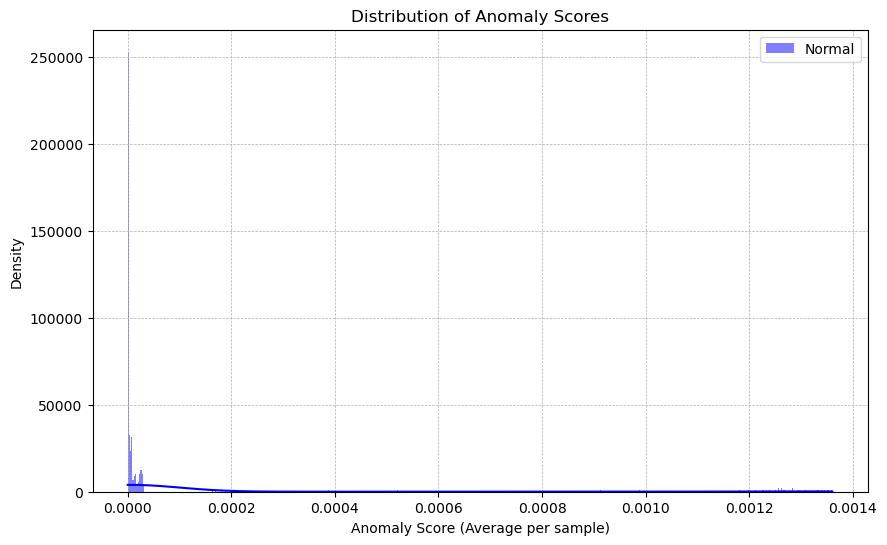

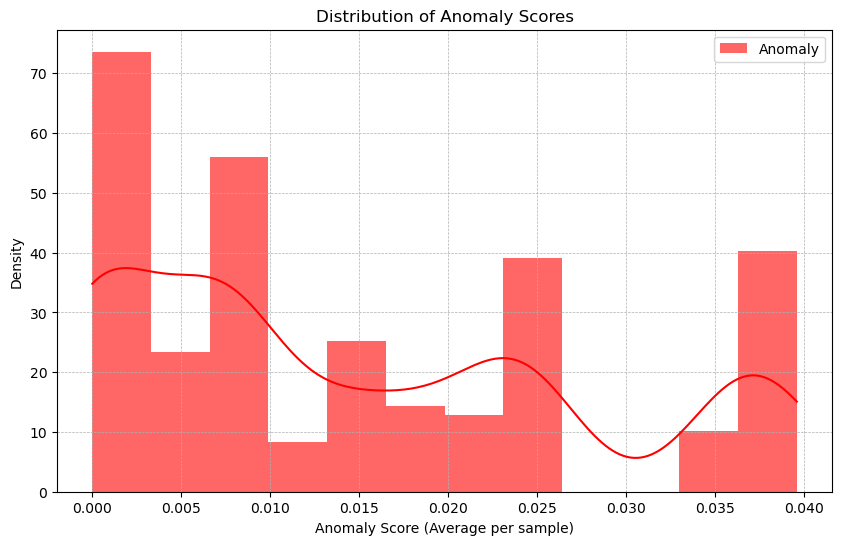

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(scores_per_sample[np.where(labels == 0)[0]], color="blue", label="Normal", kde=True, stat="density", linewidth=0)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score (Average per sample)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(scores_per_sample[np.where(labels == 1)[0]], color="red", label="Anomaly", kde=True, stat="density", linewidth=0, alpha=0.6)
plt.title('Distribution of Anomaly Scores')
plt.xlabel('Anomaly Score (Average per sample)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

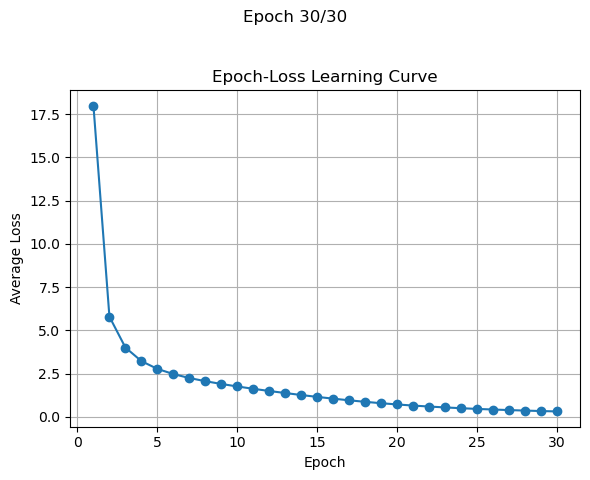

訓練完成！

正在產生測試資料...
正在進行預測...
分數檢查通過：所有異常分數均不為0。


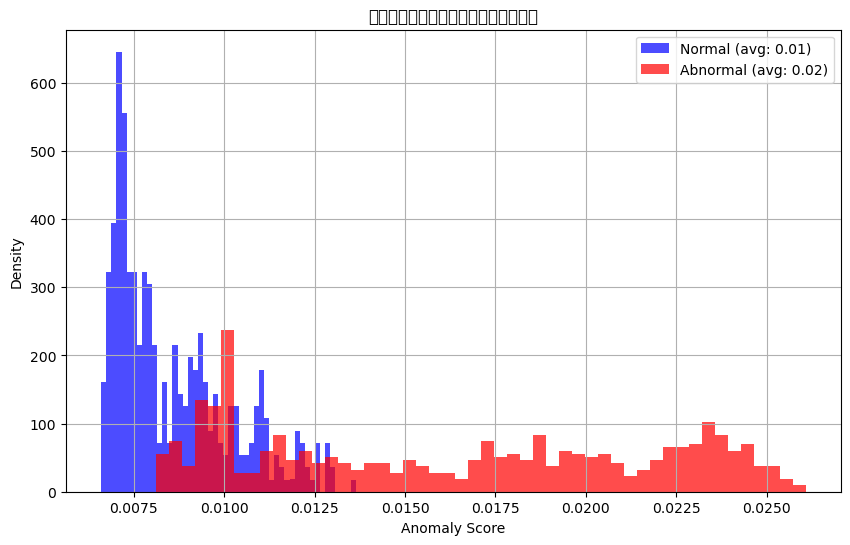

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, repeat
from IPython.display import display, clear_output
import math
import warnings

# 忽略 Matplotlib 可能產生的 UserWarning
warnings.filterwarnings("ignore", category=UserWarning)

# --- 輔助模組 (Helper Modules) ---
class InstanceNorm(nn.Module):
    def __init__(self, features, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.affine = nn.Linear(features, features)

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        var = torch.var(x, dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        x = self.affine(x)
        return x

class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv1d(
            in_channels=c_in,
            out_channels=d_model,
            kernel_size=3,
            padding=1,
            padding_mode='circular'
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x.permute(0, 2, 1)).permute(0, 2, 1)
        return self.dropout(x)

# --- 核心注意力模組 (Core Attention Module) ---
class DACStructure(nn.Module):
    # <-- 修改: 簡化DAC結構，只負責計算注意力，不進行上採樣
    def __init__(self, n_heads, d_model, dropout=0.1):
        super().__init__()
        self.n_heads = n_heads
        d_head = d_model // n_heads
        self.scale = d_head ** -0.5
        
        # 共享的權重矩陣
        self.to_qkv = nn.Linear(d_model, d_model * 3, bias=False)
        self.to_out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_pw, x_ip):
        # Patch-wise Attention (在 Patch 之間)
        qkv_pw = self.to_qkv(x_pw).chunk(3, dim=-1)
        q_pw, k_pw, v_pw = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h=self.n_heads), qkv_pw)
        dots_pw = torch.matmul(q_pw, k_pw.transpose(-1, -2)) * self.scale
        attn_pw = torch.softmax(dots_pw, dim=-1)
        out_pw = torch.matmul(self.dropout(attn_pw), v_pw)
        out_pw = self.to_out(rearrange(out_pw, 'b h n d -> b n (h d)'))
        
        # In-patch Attention (在 Patch 內部)
        qkv_ip = self.to_qkv(x_ip).chunk(3, dim=-1)
        q_ip, k_ip, v_ip = map(lambda t: rearrange(t, 'b p (h d) -> b h p d', h=self.n_heads), qkv_ip)
        dots_ip = torch.matmul(q_ip, k_ip.transpose(-1, -2)) * self.scale
        attn_ip = torch.softmax(dots_ip, dim=-1)
        out_ip = torch.matmul(self.dropout(attn_ip), v_ip)
        out_ip = self.to_out(rearrange(out_ip, 'b h p d -> b p (h d)'))

        return out_pw, out_ip

class EncoderLayer(nn.Module):
    # <-- 修改: 調整為標準的Transformer Encoder Block
    def __init__(self, n_heads, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        self.attention = DACStructure(n_heads, d_model, dropout)
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1_pw = nn.LayerNorm(d_model)
        self.norm1_ip = nn.LayerNorm(d_model)
        self.norm2_pw = nn.LayerNorm(d_model)
        self.norm2_ip = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = nn.GELU()

    def forward(self, x_pw, x_ip):
        # 1. Attention + Residual + Norm
        attn_out_pw, attn_out_ip = self.attention(x_pw, x_ip)
        x_pw = self.norm1_pw(x_pw + self.dropout(attn_out_pw))
        x_ip = self.norm1_ip(x_ip + self.dropout(attn_out_ip))

        # 2. FeedForward + Residual + Norm
        y_pw = self.dropout(self.activation(self.conv1(x_pw.transpose(-1, 1))))
        y_pw = self.dropout(self.conv2(y_pw).transpose(-1, 1))
        x_pw = self.norm2_pw(x_pw + y_pw)

        y_ip = self.dropout(self.activation(self.conv1(x_ip.transpose(-1, 1))))
        y_ip = self.dropout(self.conv2(y_ip).transpose(-1, 1))
        x_ip = self.norm2_ip(x_ip + y_ip)
        
        return x_pw, x_ip

# --- 主模型 (DCdetector Model) ---
class DCdetector(nn.Module):
    def __init__(self, win_size, enc_in, patch_sizes, n_heads, d_model, e_layers, d_ff, dropout):
        super().__init__()
        self.win_size = win_size
        self.enc_in = enc_in
        self.patch_sizes = patch_sizes
        self.d_model = d_model
        self.norm = InstanceNorm(enc_in)
        
        self.embedding_patch_wise = nn.ModuleList()
        self.embedding_in_patch = nn.ModuleList()
        for p_size in patch_sizes:
            num_patches = win_size // p_size
            self.embedding_patch_wise.append(DataEmbedding(p_size, d_model, dropout))
            self.embedding_in_patch.append(DataEmbedding(num_patches, d_model, dropout))

        self.encoder_layers = nn.ModuleList([
            nn.ModuleList([
                EncoderLayer(n_heads, d_model, d_ff, dropout)
                for _ in range(e_layers)
            ]) for _ in patch_sizes
        ])

    def forward(self, x):
        # <-- 修改: 調整 forward 邏輯，將上採樣移至Encoder之後
        B, L, C = x.shape
        x = self.norm(x)
        x = rearrange(x, 'b l c -> (b c) l 1').squeeze(-1)
        
        final_rep_pw = torch.zeros(B*C, L, self.d_model).to(x.device)
        final_rep_ip = torch.zeros(B*C, L, self.d_model).to(x.device)
        
        for i, p_size in enumerate(self.patch_sizes):
            num_patches = L // p_size
            
            # Patching
            x_pw_pre_embed = rearrange(x, 'b (n p) -> b n p', p=p_size)
            x_ip_pre_embed = rearrange(x, 'b (p n) -> b p n', p=p_size)
            
            # Embedding
            x_pw = self.embedding_patch_wise[i](x_pw_pre_embed)
            x_ip = self.embedding_in_patch[i](x_ip_pre_embed)
            
            # Encoder Stack (在 Patch 層級完成所有編碼)
            for layer in self.encoder_layers[i]:
                x_pw, x_ip = layer(x_pw, x_ip)

            # Upsampling (在所有 Encoder Layer 之後)
            upsampled_pw = repeat(x_pw, 'b n d -> b (n p) d', p=p_size)
            upsampled_ip = repeat(x_ip, 'b p d -> b (n p) d', n=num_patches)
            
            # 累加到最終表示 (現在維度保證一致)
            final_rep_pw += upsampled_pw
            final_rep_ip += upsampled_ip

        # 平均多尺度的結果
        final_rep_pw /= len(self.patch_sizes)
        final_rep_ip /= len(self.patch_sizes)
        
        # 還原維度並在通道上取平均
        final_rep_pw = rearrange(final_rep_pw, '(b c) l d -> b l c d', c=C)
        final_rep_ip = rearrange(final_rep_ip, '(b c) l d -> b l c d', c=C)
        return final_rep_pw.mean(dim=2), final_rep_ip.mean(dim=2)

# --- Agent 類別 (與之前相同，無需修改) ---
class Agent:
    def __init__(self, win_size, channels, device):
        self.device = device
        
        self.model_config = {
            'win_size': win_size,
            'enc_in': channels,
            'patch_sizes': [3, 5, 7],
            'n_heads': 2,
            'd_model': 128,
            'e_layers': 2,
            'd_ff': 256,
            'dropout': 0.1
        }
        
        self.model = DCdetector(**self.model_config).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

    def _calculate_loss(self, rep_pw, rep_ip):
        rep_pw_prob = torch.softmax(rep_pw, dim=-1) + 1e-8
        rep_ip_prob = torch.softmax(rep_ip, dim=-1) + 1e-8
        loss_pw = nn.functional.kl_div(rep_pw_prob.log(), rep_ip_prob.detach(), reduction='batchmean')
        loss_ip = nn.functional.kl_div(rep_ip_prob.log(), rep_pw_prob.detach(), reduction='batchmean')
        return loss_pw + loss_ip

    def _calculate_anomaly_score(self, rep_pw, rep_ip):
        rep_pw_prob = torch.softmax(rep_pw, dim=-1)
        rep_ip_prob = torch.softmax(rep_ip, dim=-1)
        score_pw = torch.sum(nn.functional.kl_div(rep_pw_prob.log(), rep_ip_prob, reduction='none'), dim=(-1, -2))
        score_ip = torch.sum(nn.functional.kl_div(rep_ip_prob.log(), rep_pw_prob, reduction='none'), dim=(-1, -2))
        return (score_pw + score_ip).cpu().numpy()

    def train(self, dataloader, epochs, val_dataloader=None):
        self.model.train()
        epoch_losses = []
        for epoch in range(epochs):
            total_loss = 0
            for i, (batch_x, _) in enumerate(dataloader):
                self.optimizer.zero_grad()
                batch_x = batch_x.float().to(self.device)
                rep_pw, rep_ip = self.model(batch_x)
                loss = self._calculate_loss(rep_pw, rep_ip)
                if loss.item() == 0:
                    print("警告：損失為0，模型可能已崩潰！")
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            epoch_losses.append(avg_loss)
            
            if (epoch + 1) % 10 == 0:
                clear_output(wait=True)
                fig, axes = plt.subplots(1, 2 if val_dataloader else 1, figsize=(12 if val_dataloader else 6, 5))
                fig.suptitle(f"Epoch {epoch + 1}/{epochs}")
                ax1 = axes[0] if val_dataloader else axes
                ax1.plot(range(1, epoch + 2), epoch_losses, marker='o')
                ax1.set_title("Epoch-Loss Learning Curve")
                ax1.set_xlabel("Epoch")
                ax1.set_ylabel("Average Loss")
                ax1.grid(True)
                
                if val_dataloader:
                    scores, labels = self.predict(val_dataloader, return_labels=True)
                    normal_scores = scores[labels == 0]
                    abnormal_scores = scores[labels == 1]
                    ax2 = axes[1]
                    ax2.hist(normal_scores, bins=50, alpha=0.7, label='Normal', color='blue')
                    if len(abnormal_scores) > 0:
                       ax2.hist(abnormal_scores, bins=50, alpha=0.7, label='Abnormal', color='red')
                    ax2.set_title("Anomaly Score Distribution (Val Set)")
                    ax2.set_xlabel("Score")
                    ax2.set_ylabel("Frequency")
                    ax2.legend()
                    ax2.grid(True)
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
        print("訓練完成！")

    def predict(self, dataloader, return_labels=False):
        self.model.eval()
        all_scores = []
        all_labels = []
        with torch.no_grad():
            for batch_x, batch_y in dataloader:
                batch_x = batch_x.float().to(self.device)
                rep_pw, rep_ip = self.model(batch_x)
                scores = self._calculate_anomaly_score(rep_pw, rep_ip)
                all_scores.append(scores)
                if return_labels:
                    all_labels.append(batch_y.cpu().numpy())
        all_scores = np.concatenate(all_scores)
        if return_labels:
            all_labels = np.concatenate(all_labels)
            return all_scores, all_labels
        return all_scores

# --- 資料處理 (與之前相同，無需修改) ---
def sliding_window(ts, window_size, stride=1):
    shape = ts.shape[:-1] + (ts.shape[-1] - window_size + 1, window_size)
    strides = ts.strides + (ts.strides[-1],)
    windows = np.lib.stride_tricks.as_strided(ts, shape=shape, strides=strides)
    return windows[::stride]

class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# --- 主程式 (與之前相同，無需修改) ---
if __name__ == '__main__':
    WIN_SIZE = 105
    CHANNELS = 1
    N_SAMPLES = 2000
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用裝置: {DEVICE}")

    print("正在產生訓練資料...")
    t = np.linspace(0, 100, N_SAMPLES)
    normal_ts = np.sin(t * 0.5) + np.random.normal(0, 0.1, N_SAMPLES)
    train_windows = sliding_window(normal_ts, WIN_SIZE)
    train_windows = np.expand_dims(train_windows, axis=-1)
    train_labels = np.zeros(len(train_windows))
    train_dataset = TimeSeriesDataset(train_windows, train_labels)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    
    agent = Agent(win_size=WIN_SIZE, channels=CHANNELS, device=DEVICE)
    print("開始訓練模型...")
    agent.train(train_loader, epochs=30) 

    print("\n正在產生測試資料...")
    test_normal_ts = np.sin(np.linspace(100, 120, 500) * 0.5) + np.random.normal(0, 0.1, 500)
    abnormal_ts_1 = np.sin(np.linspace(120, 130, 200) * 0.5) + np.random.normal(0, 0.5, 200)
    abnormal_ts_2 = np.random.normal(0, 0.8, 200)
    abnormal_ts_3 = np.sin(np.linspace(130, 140, 200) * 2.0) + np.random.normal(0, 0.1, 200)
    test_ts = np.concatenate([test_normal_ts, abnormal_ts_1, abnormal_ts_2, abnormal_ts_3])
    test_labels_ts = np.concatenate([np.zeros(len(test_normal_ts)), np.ones(len(abnormal_ts_1)), np.ones(len(abnormal_ts_2)), np.ones(len(abnormal_ts_3))])
    test_windows = sliding_window(test_ts, WIN_SIZE)
    test_windows = np.expand_dims(test_windows, axis=-1)
    test_labels_windows = np.array([1 if np.sum(l) > 0 else 0 for l in sliding_window(test_labels_ts, WIN_SIZE)])
    test_dataset = TimeSeriesDataset(test_windows, test_labels_windows)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

    print("正在進行預測...")
    scores, labels = agent.predict(test_loader, return_labels=True)
    normal_scores = scores[labels == 0]
    abnormal_scores = scores[labels == 1]
    assert not np.any(scores == 0), "錯誤：異常分數出現了0！"
    print("分數檢查通過：所有異常分數均不為0。")
    
    plt.figure(figsize=(10, 6))
    plt.hist(normal_scores, bins=50, alpha=0.7, label=f'Normal (avg: {np.mean(normal_scores):.2f})', color='blue', density=True)
    plt.hist(abnormal_scores, bins=50, alpha=0.7, label=f'Abnormal (avg: {np.mean(abnormal_scores):.2f})', color='red', density=True)
    plt.title("測試集上正常與異常樣本的分數分佈圖")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()